In [2]:
# ============================================================
# 0️ Configuración inicial y librerías
# ============================================================
import sys
import os
from pathlib import Path
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

# Ajustar ruta raíz del proyecto para importar src
root_path = Path(os.getcwd()).parent  # asumimos que notebooks/ está en la raíz
sys.path.append(str(root_path))

# Directorio donde se guardarán los modelos entrenados
model_dir = Path(root_path) / "models"
model_dir.mkdir(exist_ok=True)

# ML y Scikit-Learn
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

# Modelos
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Nuestro código
from src.data.load_data import ARFFLoader
from src.features.feature_engineering import FeatureEngineering
from src.models.train_models import PipelineML
from src.visualization.plot_utils import Visualizer
viz = Visualizer()

# MLflow
import mlflow
import mlflow.sklearn
from  mlflow.models import infer_signature
from src.models.mlflow import MLflowServer
from src.models.mlflow import MLflowTracker

# MLflow - Ruta de almacenamiento
MLFLOW_ARTIFACT_ROOT_PATH = (root_path / "mlruns").resolve()
MLFLOW_ARTIFACT_ROOT_PATH.mkdir(exist_ok=True)
TRACKING_URI = MLFLOW_ARTIFACT_ROOT_PATH.as_uri()

# Instancia del servidor MLflow, usando ruta local.
experiment_name = f"CEE-Experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}"

mlflow_server_handler = MLflowServer(
    experiment_name=experiment_name,
    host="127.0.0.1",
    port=5000,
    tracking_uri=TRACKING_URI,
    backend_store_path=MLFLOW_ARTIFACT_ROOT_PATH # Usamos la ruta local (Path)
)

# Inicia el servidor UI de MLflow en segundo plano
mlflow_server_handler.start_ui(background=True)

# set experiment
mlflow.set_experiment(experiment_name)

2025/11/09 17:11:05 INFO mlflow.tracking.fluent: Experiment with name 'CEE-Experiment_20251109_171105' does not exist. Creating a new experiment.


⚠️ MLflow UI ya corriendo en http://127.0.0.1:5000


<Experiment: artifact_location='file:///Users/carlosisaacsagrerocampos/Documents/test-MLops-CEE_DATA/mlruns/318557366702805502', creation_time=1762729865437, experiment_id='318557366702805502', last_update_time=1762729865437, lifecycle_stage='active', name='CEE-Experiment_20251109_171105', tags={}>

In [5]:
# ============================================================
# 1️ Cargar datos
# ============================================================
base_path = Path.cwd().parent  # Ajustar según tu estructura
data_path = base_path / "data/raw/CEE_DATA.arff"

# Usando la clase ARFFLoader
loader = ARFFLoader(data_path)
df = loader.load()

# ============================================================
# 2️ Definir columnas categóricas y ordinales
# ============================================================
categorical_cols = ['Gender','Caste','coaching','time','Class_ten_education',
                    'twelve_education','medium','Father_occupation','Mother_occupation']

ordinal_cols = ["Class_ X_Percentage","Class_XII_Percentage"]
ord_map = ["Poor","Average","Good","Vg","Excellent"]

# ============================================================
# 3️ Preprocesamiento y creación de features con FeatureEngineering
# ============================================================
fe = FeatureEngineering(ordinal_map=ord_map)

# Combinar categorías raras
for col in categorical_cols:
    df = fe.combine_rare(df, col, threshold=0.2)

# Ordinal encoding y Academic_Score
df = fe.create_ordinal_features(df, ordinal_cols)

# Agrupar target
df['Performance_grouped'] = df['Performance'].replace({
    'Average':'Average/Good','Good':'Average/Good',
    'Vg':'Vg','Excellent':'Excellent'
})
df['Performance_num'] = LabelEncoder().fit_transform(df['Performance_grouped'])

# Features de frecuencia y mean encoding
df = fe.add_frequency_features(df, categorical_cols, target_col='Performance_num')

# ============================================================
# 4️ Preparar datos para entrenamiento
# ============================================================
X = df.drop(columns=['Performance', 'Performance_grouped', 'Performance_num'])
y = df['Performance_num']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ============================================================
# 5️ Definir modelos y parámetros (sin class_weight, SMOTE aplicado)
# ============================================================
models = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'classifier__n_estimators': [350, 400],
            'classifier__max_depth': [15, 17],
            'classifier__min_samples_leaf': [4, 5, 6],
            'classifier__min_samples_split': [14, 15, 17],
            'classifier__max_features': ['sqrt', 'log2'],
            'classifier__bootstrap': [True, False]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42,
                               tree_method='hist', n_jobs=-1),
        'params': {
            'classifier__n_estimators': [100, 150],
            'classifier__max_depth': [3, 4],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__subsample': [0.7, 0.9],
            'classifier__colsample_bytree': [0.7, 0.9],
            'classifier__gamma': [0, 1],
            'classifier__reg_alpha': [0, 0.1],
            'classifier__reg_lambda': [1, 1.5],
            'classifier__min_child_weight': [1, 3, 5]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(iterations=300, verbose=0, random_seed=42),
        'params': {
            'classifier__depth': [4, 6],
            'classifier__learning_rate': [0.05, 0.07],
            'classifier__l2_leaf_reg': [1, 3, 5],
            'classifier__border_count': [64]
        }
    },
    'ExtraTrees': {
        "model": ExtraTreesClassifier(random_state=42, n_jobs=-1),
        "params": {
           "classifier__n_estimators": [200, 400],
           "classifier__max_depth": [5, 10, None],
           "classifier__min_samples_split": [2, 5],
           "classifier__min_samples_leaf": [1, 3],
           "classifier__max_features": ["sqrt", "log2"]
        }
    }
}

FileNotFoundError: [Errno 2] No such file or directory: '/Users/carlosisaacsagrerocampos/Documents/test-MLops-CEE_DATA/data/raw/CEE_DATA.arff'

Entrenando RandomForest...
   -> Registrando parámetros y configuracion de pipeline...
   -> Entrenando y evaluando...
              precision    recall  f1-score   support

           0       0.68      0.65      0.66        65
           1       0.44      0.26      0.33        27
           2       0.46      0.62      0.53        42

    accuracy                           0.56       134
   macro avg       0.53      0.51      0.51       134
weighted avg       0.56      0.56      0.55       134



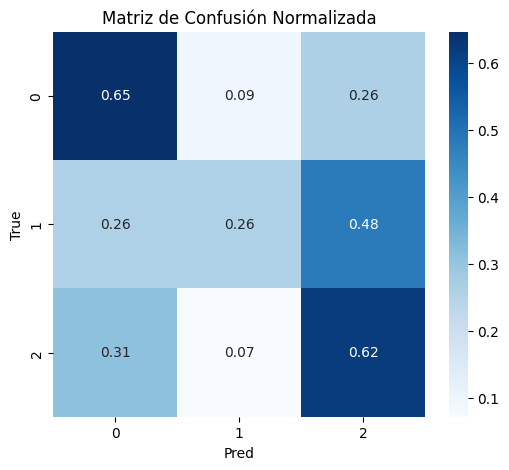

   -> Guardando métricas y modelo en MLflow...
--------------------------------------------------
Entrenando XGBoost...
   -> Registrando parámetros y configuracion de pipeline...
   -> Entrenando y evaluando...
              precision    recall  f1-score   support

           0       0.71      0.63      0.67        65
           1       0.36      0.37      0.36        27
           2       0.42      0.48      0.44        42

    accuracy                           0.53       134
   macro avg       0.49      0.49      0.49       134
weighted avg       0.55      0.53      0.54       134



<Figure size 640x480 with 0 Axes>

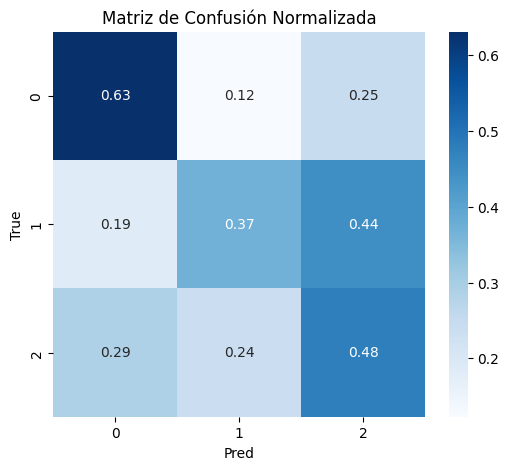

   -> Guardando métricas y modelo en MLflow...
--------------------------------------------------
Entrenando CatBoost...
   -> Registrando parámetros y configuracion de pipeline...
   -> Entrenando y evaluando...
              precision    recall  f1-score   support

           0       0.66      0.66      0.66        65
           1       0.37      0.26      0.30        27
           2       0.46      0.55      0.50        42

    accuracy                           0.54       134
   macro avg       0.50      0.49      0.49       134
weighted avg       0.54      0.54      0.54       134



<Figure size 640x480 with 0 Axes>

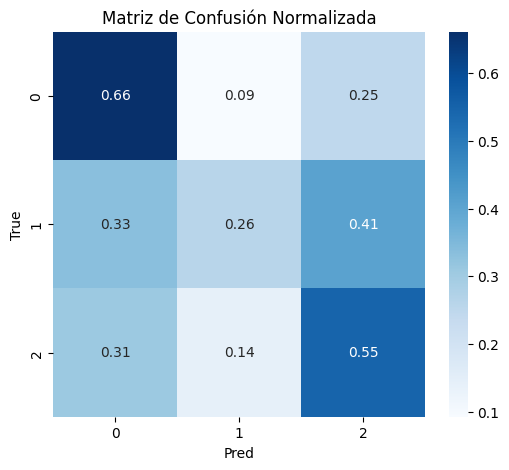

   -> Guardando métricas y modelo en MLflow...
--------------------------------------------------
Entrenando ExtraTrees...
   -> Registrando parámetros y configuracion de pipeline...
   -> Entrenando y evaluando...
              precision    recall  f1-score   support

           0       0.73      0.58      0.65        65
           1       0.38      0.56      0.45        27
           2       0.48      0.48      0.48        42

    accuracy                           0.54       134
   macro avg       0.53      0.54      0.52       134
weighted avg       0.58      0.54      0.55       134



<Figure size 640x480 with 0 Axes>

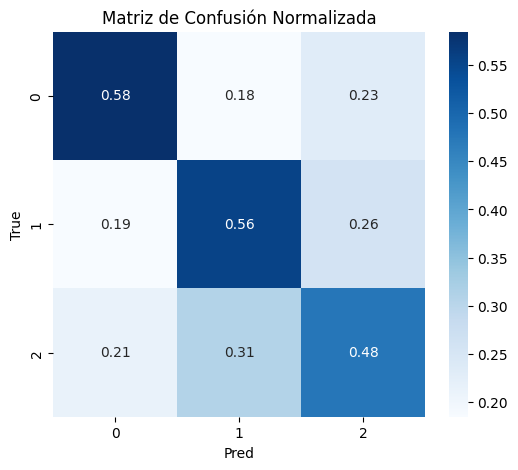

   -> Guardando métricas y modelo en MLflow...
--------------------------------------------------
Resumen guardado en C:\Users\Jesus Tamez\Desktop\MLOps_Proyecto\test-MLops-CEE_DATA\results\summary_20251030_0018.csv


<Figure size 640x480 with 0 Axes>

In [ ]:
# ============================================================
# 6️ Instanciar PipelineML y entrenar todos los modelos
# ============================================================
# Inicializa Tracker MLFlow
ml_tracker = MLflowTracker(
    experiment_name=experiment_name,
    tracking_uri=TRACKING_URI
)

# Pipelone de Modelos y Validacion cruzada
pipeline_ml = PipelineML(model_dir=model_dir, mlflow_experiment=experiment_name, cv=5)

# Identificación de features numéricas y categóricas
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# Definición del preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# -------------------------------------------------------
# Bucle de entrenamiento y registro con MLflow
# -------------------------------------------------------
for model_name, model_dict in models.items():
    print(f"Entrenando {model_name}...")

    # Pipeline con SMOTE + preprocesador + clasificador
    pipe = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', model_dict['model'])
    ])
    
    # Inicia el Run de MLflow
    with mlflow.start_run(run_name=model_name):
        
        # 1. Registro de parametros y configuraciones del pipeline
        print(f"   -> Registrando parámetros y configuracion de pipeline...")
        ml_tracker.log_pipeline_params(
            model_params=model_dict.get("params", {}),
            preprocessing="StandardScaler + OneHotEncoder",
            imbalance_technique="SMOTE",
            cv=pipeline_ml.cv
        )
        
        # 2. Entrenamiento, Evaluación y Registro de Métricas
        print(f"   -> Entrenando y evaluando...")
        best_model, best_score, best_params, save_path, y_pred = pipeline_ml.train_and_evaluate_model(
            pipe,
            X_train,
            y_train,
            X_test,
            y_test,
            params=model_dict.get("params", {})
        )

        viz.log_confusion_matrix(y_test, y_pred, title=f"Matriz de Confusión: {model_name}")
        
        viz.log_metrics_bar({model_name: best_score}, title=f"Métricas: {model_name}")

        # 3. Registro de metricas y artefactos
        print("   -> Guardando métricas y modelo en MLflow...")
        ml_tracker.log_model_results(
            model=best_model,
            metrics={"F1_CV": best_score},
            best_params=best_params,
            artifact_path="model",
            save_path=save_path
        )

    
    print("-" * 50)

# ============================================================
# 7️ Guardar resumen de resultados
# ============================================================
results_dir = base_path / "results"
results_dir.mkdir(exist_ok=True)
summary_path = results_dir / f"summary_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"

summary = pd.DataFrame(pipeline_ml.results_summary)  # todos los modelos
summary.to_csv(summary_path, index=False)

print(f"Resumen guardado en {summary_path}")